<a href="https://colab.research.google.com/github/xy2119/Brain_MRI_Image_Segmentation/blob/main/notebooks/TumorSeg_API_U_Net_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Image Segmentation for Brain Tumor | U-Net with Pretrained VGG19
# Further API Development for Clinical Application
My team and I were able to achieve winning in the 2021 DSI Computer Vision Challenge by investigating numerous ways for improving the performance of U-Net prediction during training.

For me, however, this is not the end of the story. AI has many potential applications in healthcare, how they are put to use, yet, will rely on the knowledge and experience of the people who will be putting their trust in it.

**To provide solutions for real-world applications**, I further improved the U-Net (testset dice score=81%) and turned it into a **Tumor Segmentation API** that could be used for effective early screening and diagnosis.

In this notebook, I retrained U-Net on a larger Kaggle dataset, augmented the data, and utilised pre-trained VGG19 (deeper compared to VGG16 we used in the challenge submission) as U-Net's encoder to obtain a more robust model for later API development and deployment (scripts and demo for API can be found in my repository https://github.com/xy2119/Brain_MRI_Image_Segmentation)

## **What Is a Brain Tumor?**

 A brain tumour develops when abnormal cells grow inside the brain. Tumors are classified into two types: **cancerous** (malignant) and **non-cancerous** (benign). Cancerous tumours are classified as primary tumours, which begin inside the brain, and secondary tumours, which most usually spread from cancers outside the brain and are known as brain metastasis tumours. All forms of brain tumours may cause symptoms that vary based on the section of the brain affected.
## **Semantic Segmentation**

The purpose of semantic image segmentation is to assign a class to each pixel of an image that represents what is being represented.

This notebook is organised as follows:

0. Import Libraries
1. Download Dataset
2. Vizualise MRI Images and Segmentation Masks
3. Generate Images and Masks Dataset
4. U-Net Architecture with Pretrained VGG19
5. Model Training
6. Model Evaluation


Some information might be helpful before repreducing this notebook:

* I included larger datasets into the training, with additional [LGG Segmentation Dataset](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation) from Kaggle.

Feel free to contact me at xy2119@ic.ac.uk


# Import Libraries

In [1]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage import io
from IPython.display import display

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input

from warnings import filterwarnings
#filterwarnings('ignore')

# Download Dataset

In [ ]:
#create the .kaggle folder in the root directory
!mkdir ~/.kaggle 
# write kaggle API credentials to kaggle.json
!echo '{"username":"mancostart","key":"d5ae883c2cdbdb931ba7335620acf2fa"}' > ~/.kaggle/kaggle.json 
# set permissions
!chmod 600 ~/.kaggle/kaggle.json
# install the kaggle library
!pip install kaggle 
# download LGG Kaggle Dataset
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation -p ~/../content/segment-brain-mri/data/  
# unzip
!unzip -o ~/../content/segment-brain-mri/data/lgg-mri-segmentation.zip -d ~/../content/segment-brain-mri/data/

In [3]:
data_map = []
for sub_dir_path in glob.glob("/content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(sub_dir_path)

/content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/README.md
/content/segment-brain-mri/data/lgg-mri-segmentation/kaggle_3m/data.csv


In [4]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...
1,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...
2,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...
3,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...
4,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...


In [5]:
df_imgs = df[~df['path'].str.contains("mask")] # if have not mask
df_masks = df[df['path'].str.contains("mask")]# if have mask

# File path line length images for later sorting
BASE_LEN = 107 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [6]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
1,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
2,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
3,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
4,TCGA_HT_7855_19951020,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
...,...,...,...,...
3924,TCGA_DU_7299_19910417,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
3925,TCGA_DU_7299_19910417,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
3926,TCGA_DU_7299_19910417,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0
3927,TCGA_DU_7299_19910417,/content/segment-brain-mri/data/lgg-mri-segmen...,/content/segment-brain-mri/data/lgg-mri-segmen...,0


# Vizualise MRI Images and Segmentation Masks

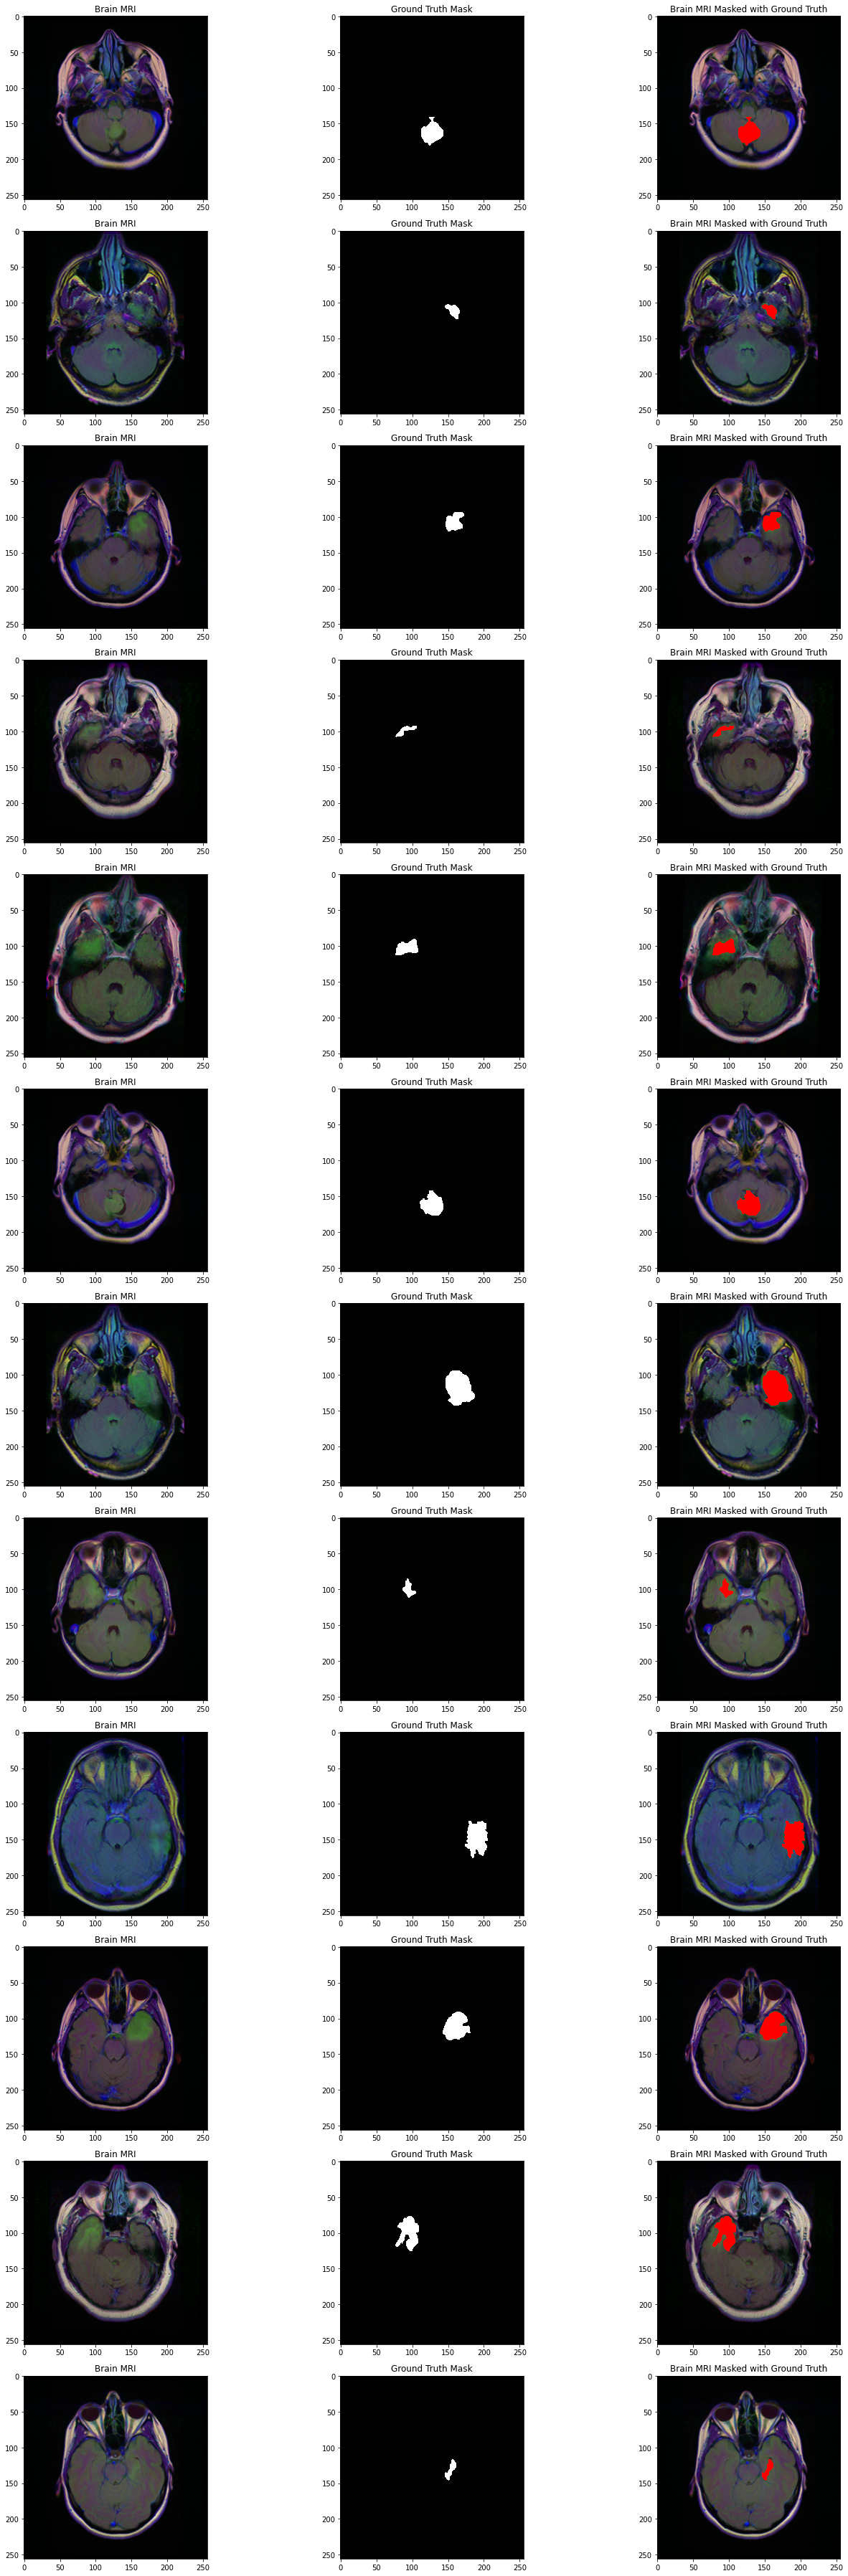

In [7]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Ground Truth Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("Brain MRI Masked with Ground Truth")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# Generate Images and Masks Dataset

In [8]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [9]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [10]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, Valid size is {}, Test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, Valid size is 103, Test size is 103


In [11]:
from keras_preprocessing.image import ImageDataGenerator

# Define data generator
def data_generator(data_frame, batch_size, aug_dict, 
                   image_color_mode="rgb",mask_color_mode="grayscale",
                   image_save_prefix="image", mask_save_prefix="mask",
                   target_size=(256,256), 
                   save_to_dir=None, seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    data_gen = zip(image_generator, mask_generator)
    for (img, mask) in data_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [12]:
BATCH_SIZE = 32
im_height = 256
im_width = 256

train_generator_args = dict(width_shift_range=0.05,
                            height_shift_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = data_generator(X_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
val_gen= data_generator(X_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

test_gen= data_generator(X_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))


# U-Net Architecture with Pretrained VGG19

In [13]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights=None, input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model
model = build_vgg19_unet((256,256,3))
model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [14]:
# Define loss function 
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [19]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, 
              loss=dice_coef_loss, 
              metrics=["binary_accuracy", iou, dice_coef]
                 )
# callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="unet_vgg19.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

# Model Training

In [20]:
BATCH_SIZE=32
history = model.fit(train_gen, 
                  epochs = 96, 
                  steps_per_epoch = int(round(len(X_train) / BATCH_SIZE)), 
                  validation_data = val_gen,
                  validation_steps = int(round(len(X_val) / BATCH_SIZE)),
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/96
36/36 [==============================] - ETA: 0s - loss: -0.8194 - binary_accuracy: 0.9896 - iou: 0.6962 - dice_coef: 0.8199
Epoch 1: val_loss improved from inf to -0.59886, saving model to unet_vgg19.h5
36/36 [==============================] - 23s 591ms/step - loss: -0.8194 - binary_accuracy: 0.9896 - iou: 0.6962 - dice_coef: 0.8199 - val_loss: -0.5989 - val_binary_accuracy: 0.9810 - val_iou: 0.4287 - val_dice_coef: 0.5989 - lr: 0.0500
Epoch 2/96
36/36 [==============================] - ETA: 0s - loss: -0.8161 - binary_accuracy: 0.9898 - iou: 0.6914 - dice_coef: 0.8158
Epoch 2: val_loss did not improve from -0.59886
36/36 [==============================] - 19s 546ms/step - loss: -0.8161 - binary_accuracy: 0.9898 - iou: 0.6914 - dice_coef: 0.8158 - val_loss: -0.3033 - val_binary_accuracy: 0.9734 - val_iou: 0.1809 - val_dice_coef: 0.3033 - lr: 0.0500
Epoch 3/96
36/36 [==============================] - ETA: 0s - loss: -0.8206 - binary_accuracy: 0.9896 - iou: 0.7030 - dice_coef

# Model Evaluation

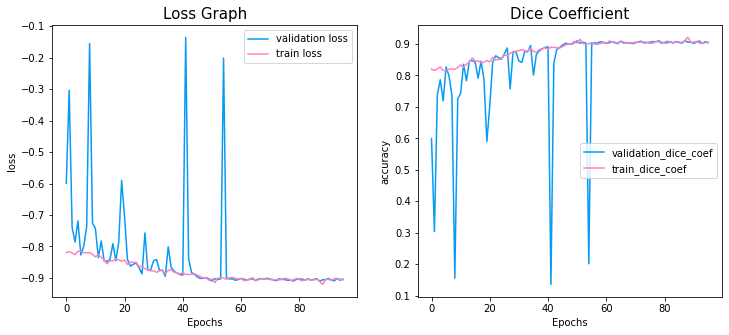

In [21]:
history = history.history

list_traindice = history['dice_coef']
list_valdice = history['val_dice_coef']

list_trainjaccard = history['iou']
list_valjaccard = history['val_iou']

list_trainloss = history['loss']
list_valloss = history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(list_valloss, '#059AF3', label='validation loss')
plt.plot(list_trainloss,'#FF81C0', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss Graph', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(list_valdice, '#059AF3', label= 'validation_dice_coef')
plt.plot(list_traindice, '#FF81C0', label= 'train_dice_coef')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Dice Coefficient', fontsize = 15)
plt.legend(['train', 'val'])
plt.legend(loc='best')
plt.show()

In [22]:
model = load_model('unet_vgg19.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
results = model.evaluate(test_gen, steps=len(X_test) / BATCH_SIZE)

print("Test Cice Coefficent Loss: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

3/3 [==============================] - 1s 106ms/step - loss: -0.8903 - binary_accuracy: 0.9946 - iou: 0.8114 - dice_coef: 0.8955 
Test Cice Coefficent Loss:  -0.8903145790100098
Test IOU:  0.9946444630622864
Test Dice Coefficent:  0.8113657236099243


1/1 [==============================] - 0s 22ms/step


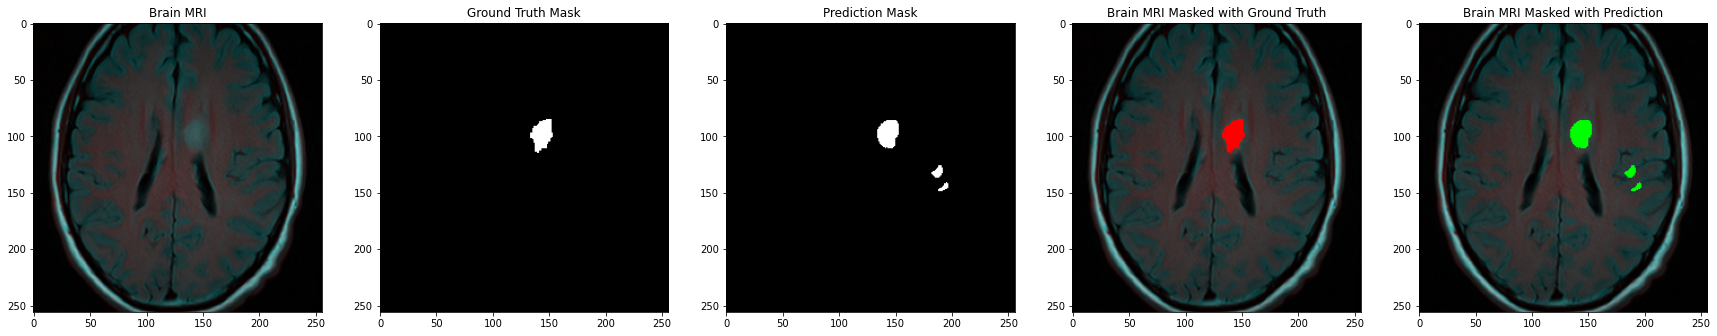

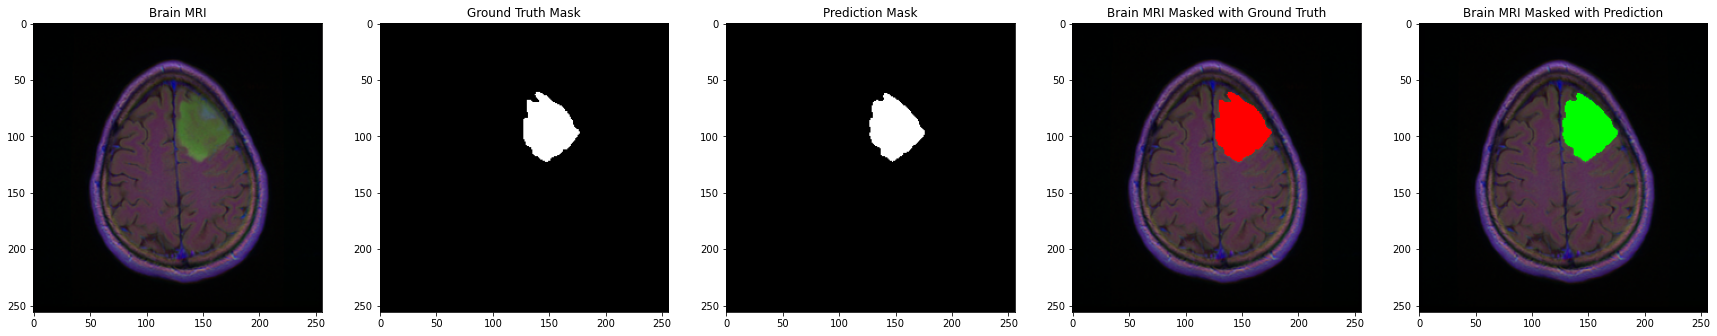

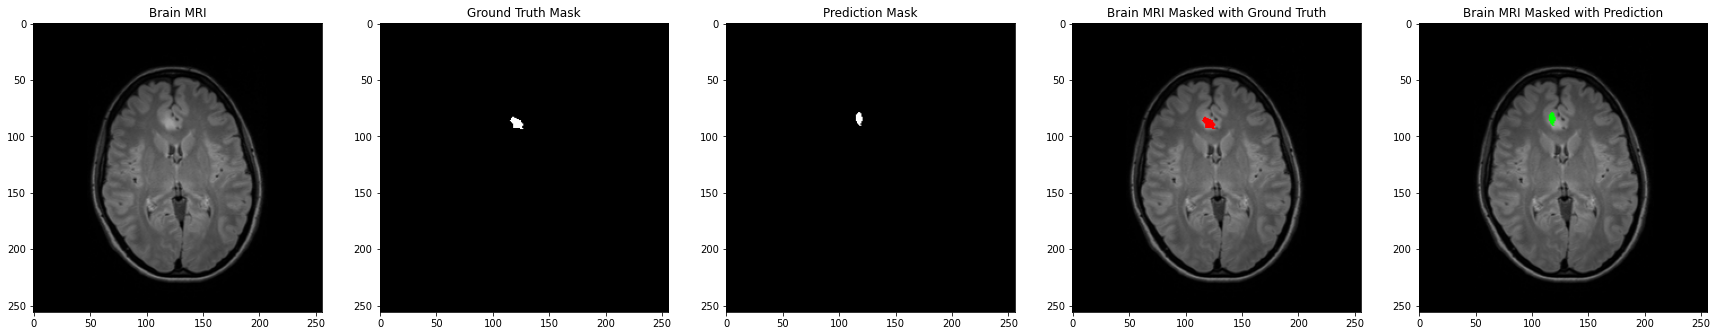

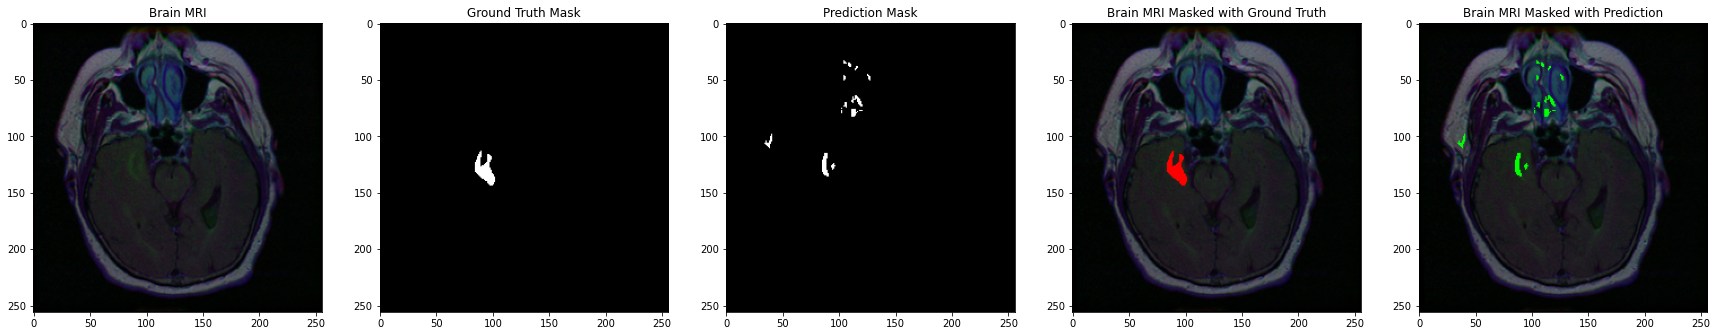

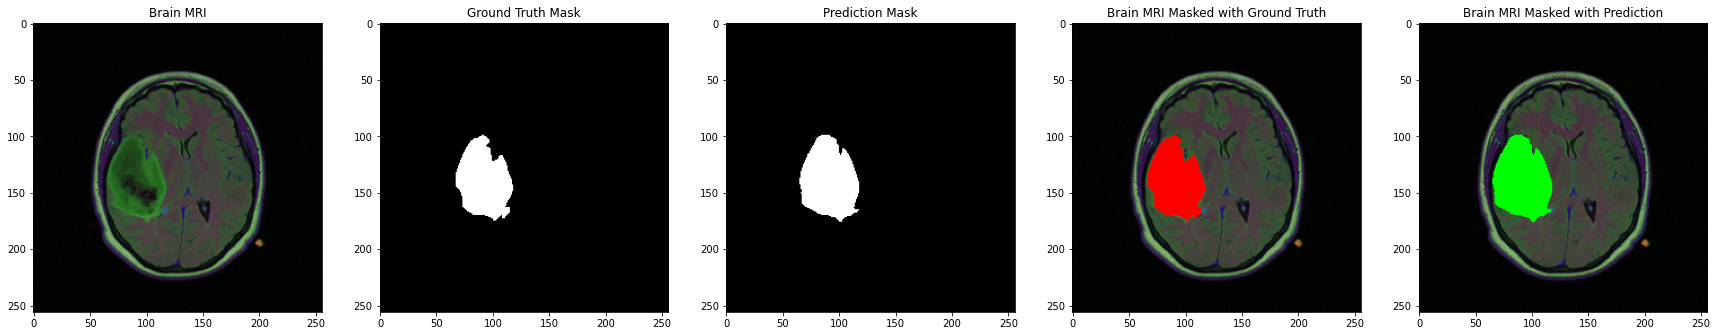

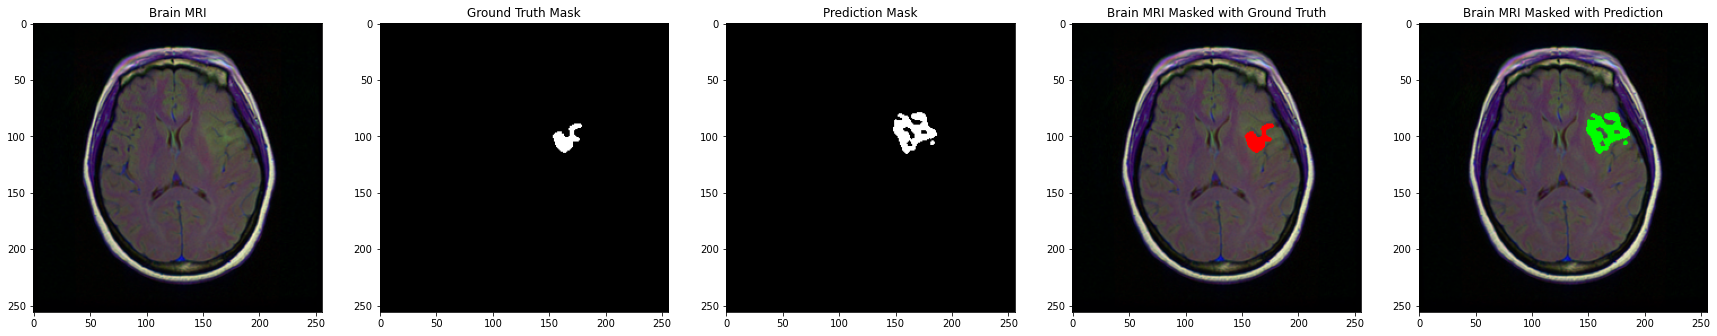

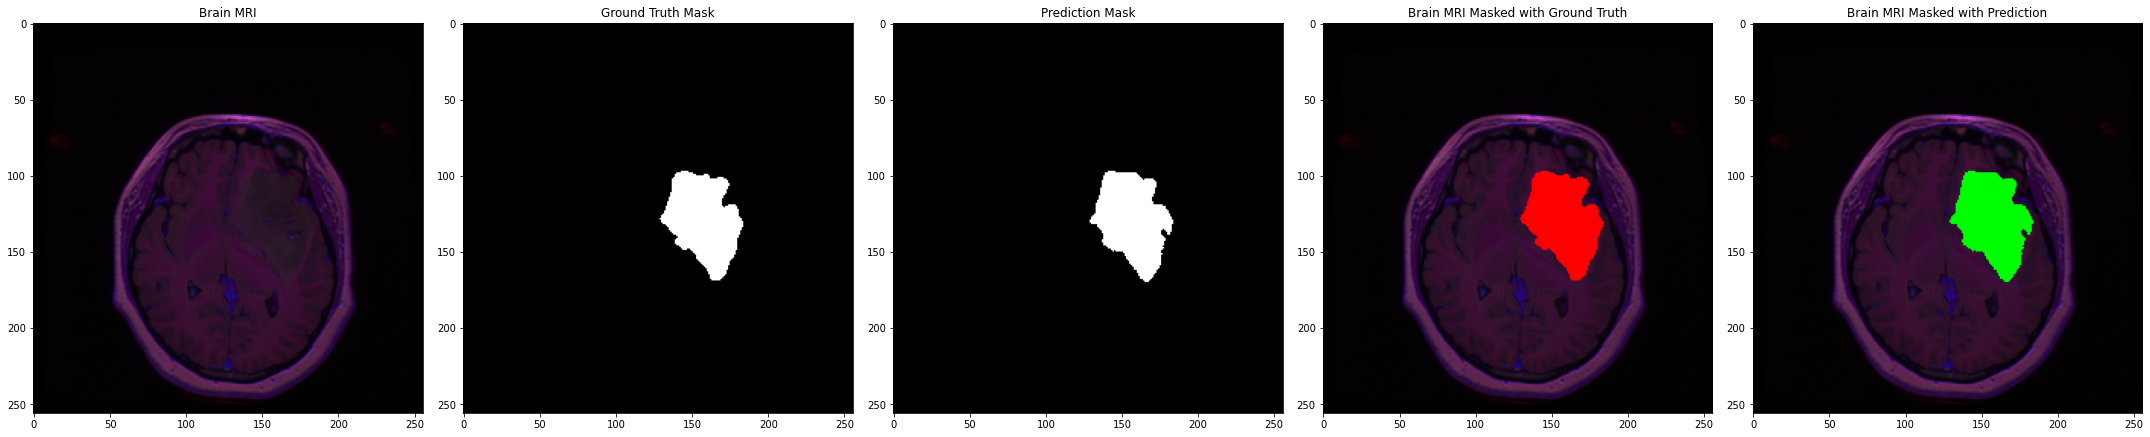

In [34]:
df_pred=X_test

for i in range(0,len(df_pred),15):
    img_path_test = X_test.iloc[i, 1]
    msk_path_test = X_test.iloc[i, 2]
    fig, axs = plt.subplots(1,5, figsize=(30,70))

    img = io.imread(img_path_test)
    axs[0].imshow(img)
    axs[0].title.set_text('Brain MRI')

    #read original mask
    mask = io.imread(msk_path_test)
    axs[1].imshow(mask,cmap='gray')
    axs[1].title.set_text('Ground Truth Mask')

    #read predicted mask
    img = cv2.imread(img_path_test)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]

    pred = model.predict(img)
    pred = np.array(pred).squeeze().round()
    axs[2].imshow(pred,cmap='gray')
    axs[2].title.set_text('Prediction Mask')

    #overlay original mask with MRI
    scan= cv2.imread(img_path_test)
    scan = cv2.cvtColor(scan, cv2.COLOR_BGR2RGB)
    label = cv2.imread(msk_path_test)
    grey = cv2.cvtColor(label,cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(grey, 225, 255, cv2.THRESH_BINARY)
    contours, hier = cv2.findContours(binary,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_pr = cv2.drawContours(scan, contours, -1, [255,0,0], thickness=-1)
    axs[3].imshow(np.squeeze(sample_over_pr))
    axs[3].title.set_text('Brain MRI Masked with Ground Truth')

    #overlay predicted mask and MRI
    scan= cv2.imread(img_path_test)
    scan = cv2.cvtColor(scan, cv2.COLOR_BGR2RGB)
    sample = np.array(np.squeeze(pred) > 0.5, dtype = np.uint8)
    contours, hier = cv2.findContours(sample,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    sample_over_pr = cv2.drawContours(scan, contours, -1, [0,255,0], thickness=-1)
    axs[4].imshow(np.squeeze(sample_over_pr))
    axs[4].title.set_text('Brain MRI Masked with Prediction')

fig.tight_layout()